<a id='preprocessing'></a>

# Preprocessing
Code [here](http://localhost:8888/edit/utils/preprocessing.py)

1. [Litterature review of methods](#litrev)
1. [Setup](#setup)
1. [Rejection](#rejection)
1. [Referencing](#ref)
1. [TFAnalysis](#TF)
1. [Baseline](#baseline)
1. [ROIs](#ROIs)
1. [Pipeline description](#top)

<a id='litrev'></a>
## Litterature review of methods

Methods are described in sections below


|    |Cleaning\* |Reference |  TF Bands | TF Method | Baseline\*\* | Other|
| :- | :- | :- | :- | :- | :- | :- |
|fedorenko2016neural | | CAR  |(70,170)Hz | Hilbert |fixation| LPF 100Hz after TF |
|lundqvist2016gamma | | | (20,35)Hz (45,100)Hz| Wavelet(f) Hilbert    |none or (-200,0)ms | Monkey ecog |
|nelson2017neurophysiological|  | Bipolar| broadband h-gamma | ? 	| none	|| Gaussian convolution (std 75ms) for plotting |
|pinheiro2018brain |std of V and dVdt, slope of psd | CAR   | (70,180)Hz  |Hybrid | (-200,0)ms ||
|woolnough2020spatiotemporal|  | CAR |(70,150)Hz | Hilbert  |(-500,-100)ms | smoothed with Savitzky–Golay 151ms |
|liberty2020topography|  | CAR |(70,150)Hz | Hybrid PCA  |none | downsample 100Hz zscore full recording |
|Yair| std of V and dVdt | CMR Bipolar |  | Hilbert  | trial based | outlier clipping|
|Théo| std of V and dVdt | CMR | Broad | (Hilbert)  | trial based |  |


\* Cleaning always includes visual inspection  
\*\* None include rescaling wrt the full reccording

<a id='setup'></a>
# Set up

Import necessary libraries and parameters.

Pipeline configuration is done through the [config file](http://localhost:8888/edit/config.py) or through explicit arguments.

In [1]:
# import packages
import numpy as np
import pandas as pd
import mne
import sys, os, glob, csv, json, mne, time

# import local modules
import utils.common_functions as cf
import utils.preprocessing as pr
import utils.overview as ov

# load parameters
import config as cfg

mne.set_log_level("CRITICAL")

<a id='rejection'></a>
## Rejection

Channel-wise rejection based on 3 observables:
1. std of the voltage
1. std of the voltage increments
1. Exponential slope of power spectral density from 10 to 200Hz

For each of the three observables outliers are found by rescaling wrt to IQR (`RobustScaler`) and thresholds given in config

In [2]:
pr.rejection_wrap()


======== rejection ==============================================

SUB	TOTAL	KEPT	REJECTED
sub-01	192	172	20	10%
sub-02	192	177	15	7%
sub-03	216	198	18	8%
sub-04	150	134	16	10%
sub-05	185	169	16	8%
sub-06	201	182	19	9%
sub-07	182	164	18	9%
sub-08	210	195	15	7%
sub-09	192	173	19	9%
sub-10	256	230	26	10%
sub-11	178	155	23	12%
sub-12	237	220	17	7%
sub-13	232	205	27	11%
sub-14	213	198	15	7%


Let's look at the rejection results for `sub-05`.  

Upper pannel shows locations of rejected electrodes in glass brain.  
Lower pannel shows statistics, one point per electrode:
- x axis: std of Voltage
- y axis: std of dV/dt
- color scale: slope of power spectral density
- Points with black edge are rejected electrodes, vertical and horizontal lines are thresholds

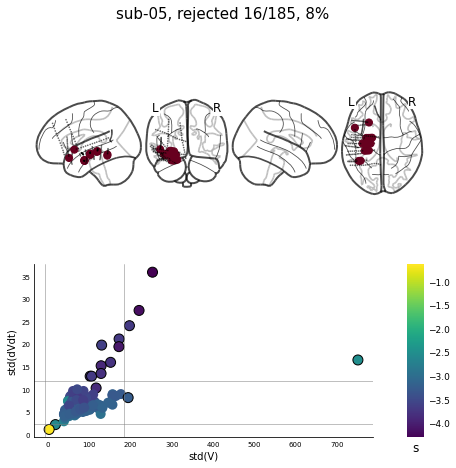

In [4]:
sub = 'sub-05'
dp = cf.sub_params(sub)
mneraw_file = os.path.join(dp['raw_path'],f"{sub}_raw.fif")
raw = mne.io.read_raw_fif(mneraw_file,preload=True)

kept, stats, thresholds = pr.rejection(raw)
pr.rejection_figure(raw,sub,dp['figures_path'],kept,stats,thresholds,plot=True)

#### EOIs
Based on the scatter plot we can identify several groups of EOIs:
- two channels with small std(V), std(dVdt) and s, probably disconnected electrodes. s \~ 0 suggests white noise.
- Multiple channels with large std(dVdt) and s
- One channel with very large std(V) but intermediate s

In [20]:
EOI = [ch for (ch, stat) in zip(raw.ch_names, stats[1]) if stat<thresholds[1][0]]
print(EOI)
EOI = [ch for (ch, stat) in zip(raw.ch_names, stats[1]) if stat>thresholds[1][1]]
print(EOI)
EOI = [ch for (ch, stat) in zip(raw.ch_names, stats[0]) if stat>500]
print(EOI)

['004-LIN4', '005-LIN5']
['012-AER1', '013-AER2', '014-AER3', '144-LOF1', '160-AH3', '161-AH4', '162-AH5', '163-AH6', '164-AH7', '175-PH4', '176-PH5', '177-PH6']
['144-LOF1']


Now use `raw.plot()` to show the ieeg data. Bad channels are marked red and the scaling has to be manualy introduced because eeg voltage ranges do not correspond to ieeg ones.

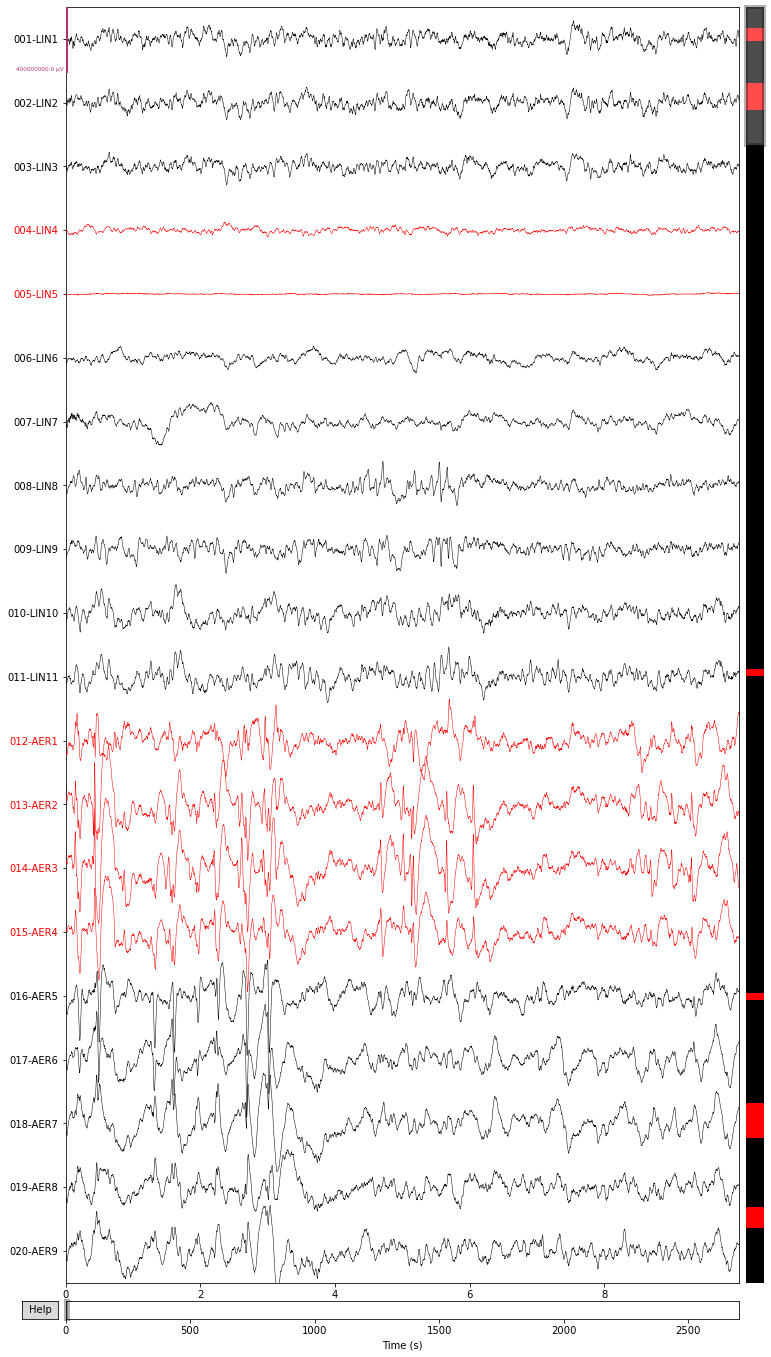

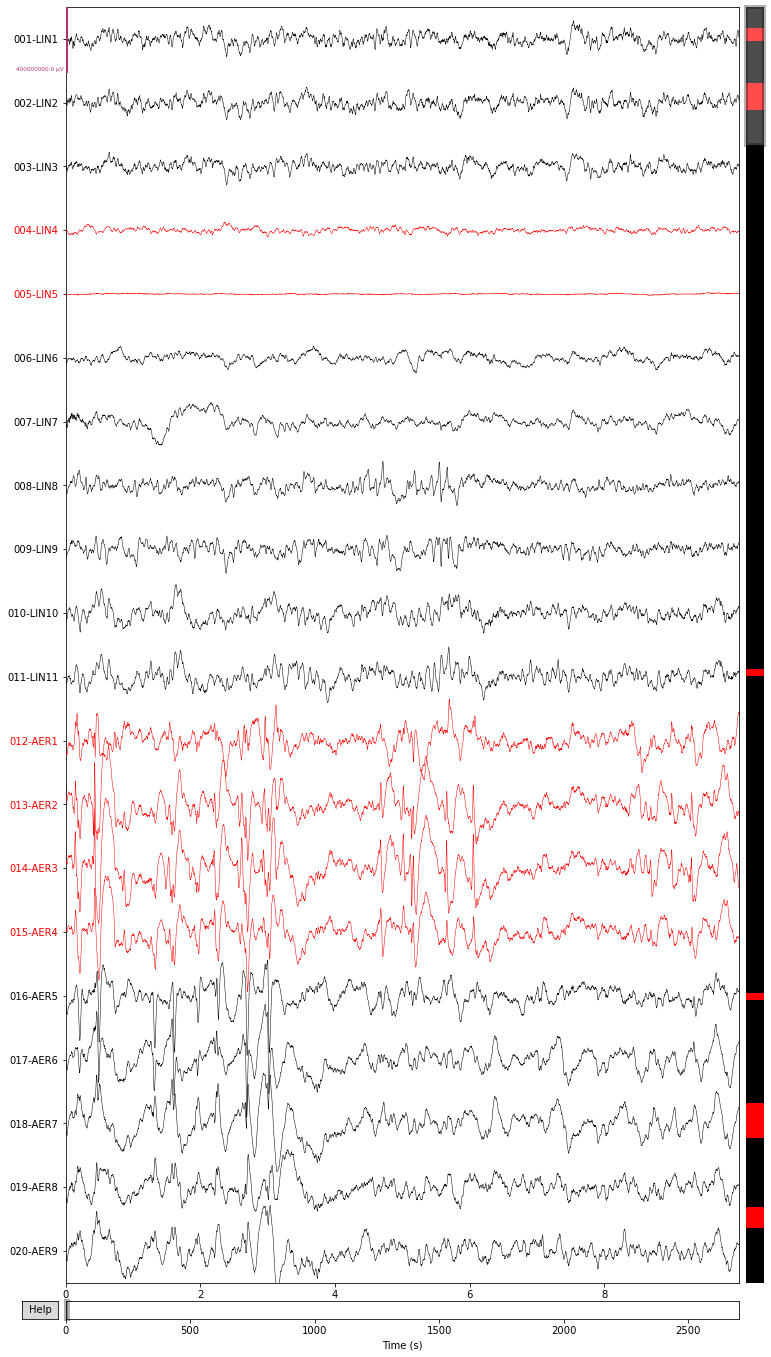

In [21]:
# mark bad channels in raw.info
raw.info['bads'] = np.array(raw.ch_names)[~kept]
raw.plot(scalings=dict(eeg=200),bad_color='r')

<a id='ref'></a>
# Referencing

Methods:
1. `'cmr'`: common median reference
1. `'car'`: common average reference
1. `'bipolar'`: reference with next electrode in the same probe
1. `'laplacian'`: reference with avg of the two first neighbor electrodes in the same probe

In [22]:
pr.referencing_wrap()


======== referencing ================================================

cmr reference done!                                                             



### Navigate
1. [Litterature review of methods](#litrev)
1. [Setup](#setup)
1. [Rejection](#rejection)
1. [Referencing](#ref)
1. [TFAnalysis](#TF)
1. [Baseline](#baseline)
1. [ROIs](#ROIs)
1. [Pipeline description](#top)


<a id='TF'></a>
# Time Frequency Analysis

|band|range|
| :- | :- | 
| broad   |(0.1,500)Hz |
| theta   |(4,8)Hz |
| alpha   |(8,13)Hz |
| beta   |(13,30)Hz |
| gamma   |(30,70)Hz |
| hgamma   |(70,140)Hz |
| bgamma   |(30,140)Hz |

TFR methods:
1. `'filter'`: band pass filter
1. `'hilbert'`: band pass filter and hilbert envelope
1. `'wavelet'`: wavelet with `nf` equaly spaced frequency centers, each frequency is normalized independently then all averaged. Normalization options:
    1. `'std'`: divide each time series by its std
    1. `'freq'`: multiply each time series by the frequency center
    1. `'PCA'`:
1. `'complex'`: band pass filter and complex hilbert transform, used for phase.
    1. in ERP plots $\theta\in(-\pi,\pi)$ is the phase of the complex time series
    1. in trace plots ITC is the inter-trial coherence as shown [here](https://www.mattcraddock.com/blog/2020/06/12/what-is-intertrial-coherence/).
    
#### Units and scaling
- For filtered and broad band **voltage** z-scored wrt all data. 
- For amplitude bands (hilbert or wavelet) **dB** z-scored wrt all data.
- For ITC, $ITC\in[0,1]$ (1 for perfectly phase-locked trials, 0 for phase uniformly distributed across trials)
- For phase $\theta\in(-\pi,\pi)$


To ilustrate the different methods we will pick an example electrode (**sub-06**, **151-PSO11**, **occipital lobe**) with a clear signal and will use the function `ov.channel_overview` from the `overview` module with modes `trace` and `ERP.`

Let's first look at the broad band signal for sentence and word epochs.  

## Broad band

Notice that broad band is computed by high pass filtering raw data in order to remove low frequency components of the signal (detrending).


======== mne.raw 2 mne.rawTFR ===================================

done! elapsed time 0 min                                                        



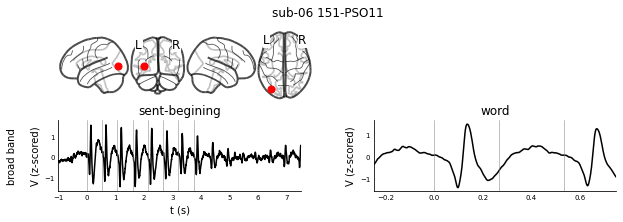

In [3]:
# define epochs
ep_setups = [  
    {"name" : "sent-begining",'key' : 'position', "values" : [ 1 ], "tmin" : -1., "tmax" : 7.5, 'baseline' : None, "xticks": [n for n in range(8)],"smooth":0.,"clip":3,"split":"sentlength" }, 
    {"name" : "word" ,'key' : "eventtype" ,"values" :  ["wordonset"], "tmin" : -0.25,"tmax" : .75, 'baseline' : None, "xticks": [0.5*n for n in range(3)],"smooth":0.,"clip":3,"split":"position" }
]

# define bands
bands = [     
  {"name": "broad", "fmin" :0.1, "fmax" : None, "method": "filter"},
]

pr.raw2TFR_wrap(subs=['sub-06'],bands=bands)

# trace plot
ov.channel_overview('trace','sub-06','151-PSO11',bands=bands,ep_setups =ep_setups)
# ERP plot
ov.channel_overview('ERP','sub-06','151-PSO11',bands=bands,ep_setups =ep_setups)

## Theta band

I define four theta bands, computed with each of the methods and identified by a suffix (e.g. `theta-h` = computed with hilbert method).

This electrode has amplitude bursts that are clearly seen in both hilbert and wavelet (0 to 250ms in word epochs) as well as oscillation in filtered. Inter-trial coherence (ITC in trace plot) and phase ($\theta$ in ERP plot) show that the the amplitude bursts correspond to phase locked activity.

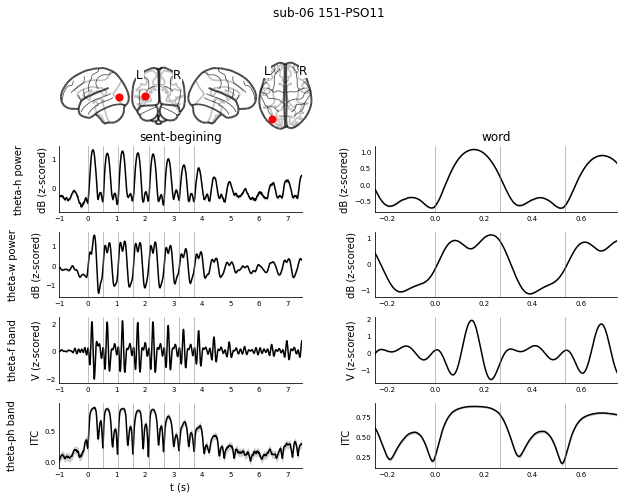

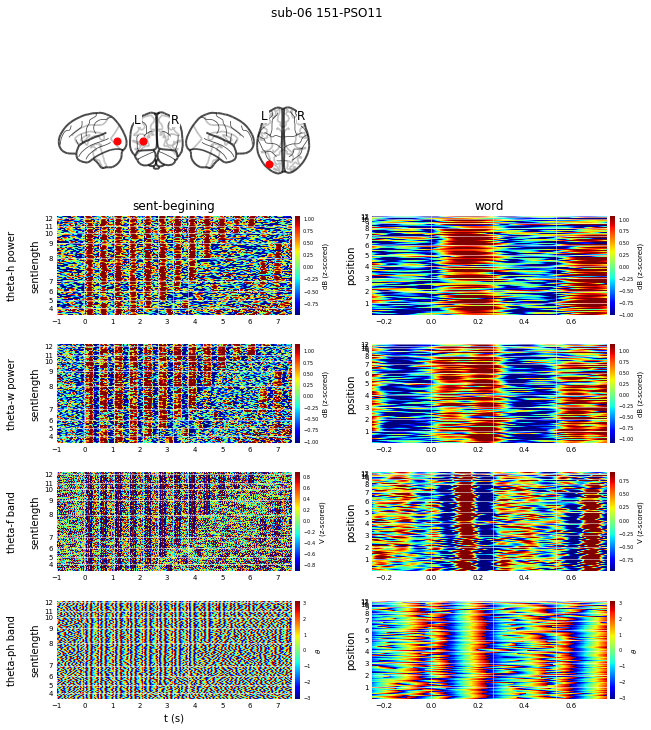

In [5]:
# define epochs
ep_setups = [  
    {"name" : "sent-begining",'key' : 'position', "values" : [ 1 ], "tmin" : -1., "tmax" : 7.5, 'baseline' : cfg.high_pass_filter, "xticks": [n for n in range(8)],"smooth":0.,"clip":3,"split":"sentlength" }, 
    {"name" : "word" ,'key' : "eventtype" ,"values" :  ["wordonset"], "tmin" : -0.25,"tmax" : .75, 'baseline' : cfg.high_pass_filter, "xticks": [0.5*n for n in range(3)],"smooth":0.,"clip":3,"split":"position" }
]


bands = [     
  {"name": "theta-h", "fmin" : 4, "fmax" : 8, "method": "hilbert" },
  {"name": "theta-w", "fmin" : 4, "fmax" : 8, "method": "wavelet",'nf':10,'norm':'f'},
  {"name": "theta-f", "fmin" :4, "fmax" : 8, "method": "filter"},
  {"name": "theta-ph", "fmin" : 4, "fmax" : 8, "method": "complex"},
]

pr.raw2TFR_wrap(subs=['sub-06'],bands=bands)

ov.channel_overview('trace','sub-06','151-PSO11',bands=bands,ep_setups =ep_setups)
ov.channel_overview('ERP','sub-06','151-PSO11',bands=bands,ep_setups =ep_setups)

## Beta band

Same as for theta

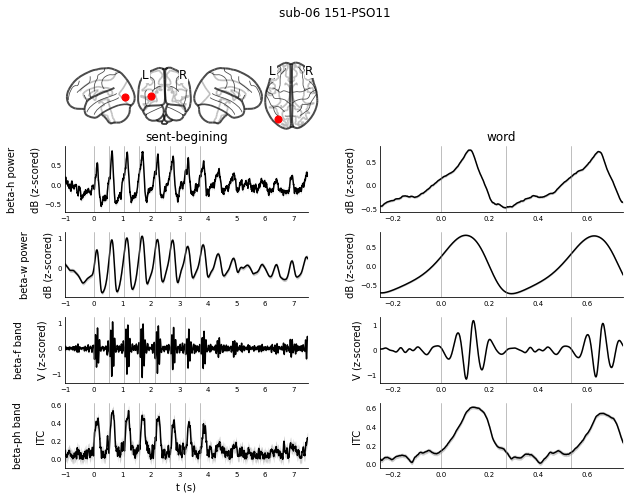

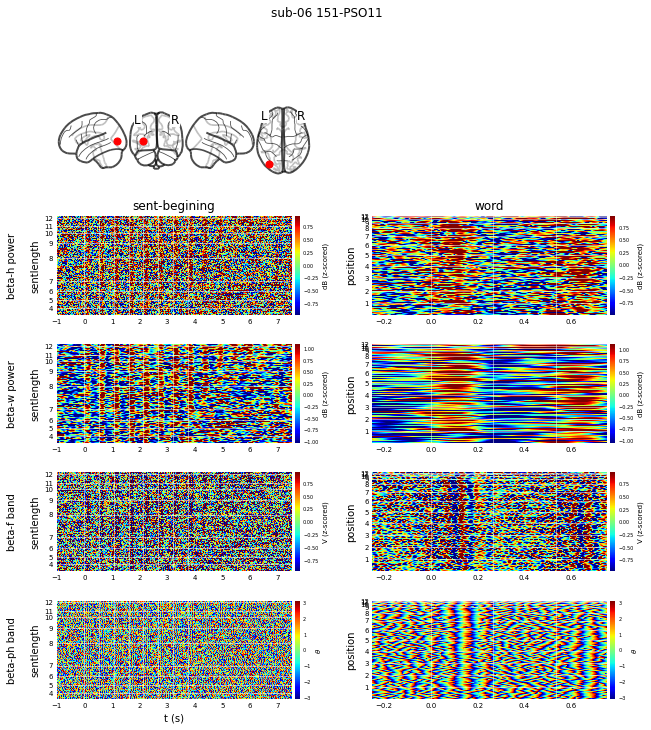

In [6]:
# define epochs
ep_setups = [  
    {"name" : "sent-begining",'key' : 'position', "values" : [ 1 ], "tmin" : -1., "tmax" : 7.5, 'baseline' : cfg.high_pass_filter, "xticks": [n for n in range(8)],"smooth":0.,"clip":3,"split":"sentlength" }, 
    {"name" : "word" ,'key' : "eventtype" ,"values" :  ["wordonset"], "tmin" : -0.25,"tmax" : .75, 'baseline' : cfg.high_pass_filter, "xticks": [0.5*n for n in range(3)],"smooth":0.,"clip":3,"split":"position" }
]


bands = [     
  {"name": "beta-h", "fmin" : 13, "fmax" : 30, "method": "hilbert" },
  {"name": "beta-w", "fmin" : 13, "fmax" : 30, "method": "wavelet",'nf':10,'norm':'f'},
  {"name": "beta-f", "fmin" :13, "fmax" : 30, "method": "filter"},
  {"name": "beta-ph", "fmin" : 13, "fmax" : 30, "method": "complex"},
]

#pr.raw2TFR_wrap(subs=['sub-06'],bands=bands)

ov.channel_overview('trace','sub-06','151-PSO11',bands=bands,ep_setups =ep_setups)
ov.channel_overview('ERP','sub-06','151-PSO11',bands=bands,ep_setups =ep_setups)

## Gamma band

Hilbert and wavelet show sustained gamma activity, wavelet shows a clearer image, hilbert has more temporal detail.  
ITC is very low at all times, activity is not phase-locked.


======== mne.raw 2 mne.rawTFR ===================================

done! elapsed time 5 min                                                        



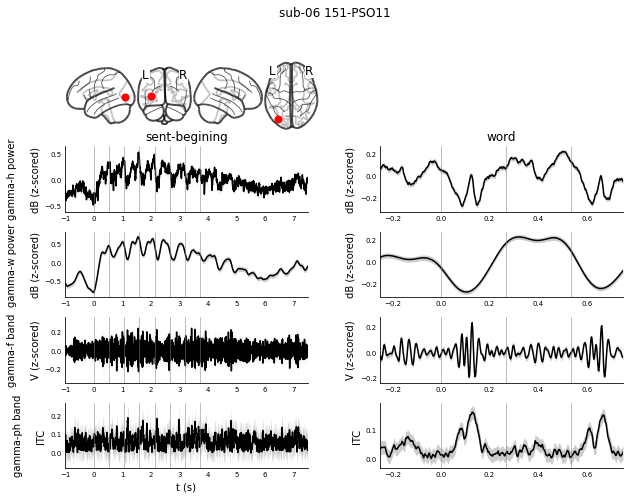

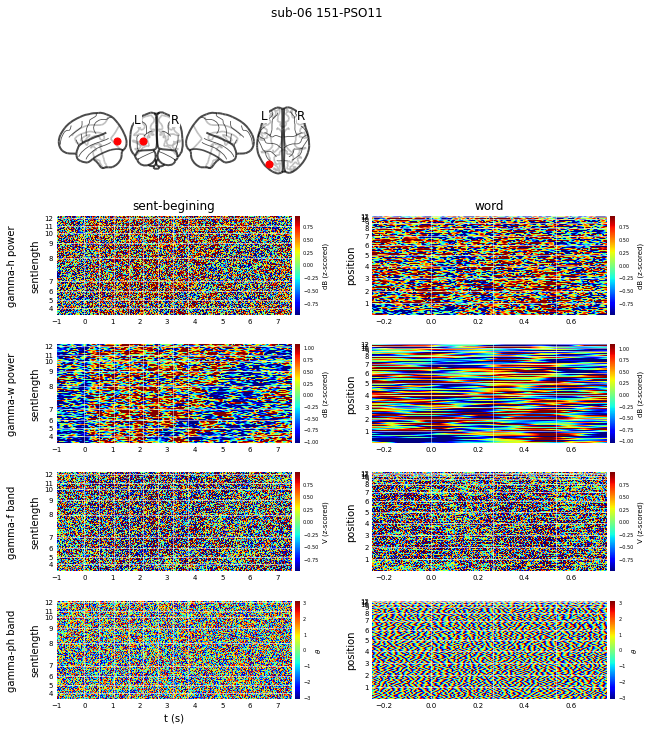

In [10]:
# define epochs
ep_setups = [  
    {"name" : "sent-begining",'key' : 'position', "values" : [ 1 ], "tmin" : -1., "tmax" : 7.5, 'baseline' : cfg.high_pass_filter, "xticks": [n for n in range(8)],"smooth":0.,"clip":3,"split":"sentlength" }, 
    {"name" : "word" ,'key' : "eventtype" ,"values" :  ["wordonset"], "tmin" : -0.25,"tmax" : .75, 'baseline' : cfg.high_pass_filter, "xticks": [0.5*n for n in range(3)],"smooth":0.,"clip":3,"split":"position" }
]


bands = [     
  {"name": "gamma-h", "fmin" : 30, "fmax" : 70, "method": "hilbert" },
  {"name": "gamma-w", "fmin" : 30, "fmax" : 70, "method": "wavelet",'nf':10,'norm':'f'},
  {"name": "gamma-f", "fmin" : 30, "fmax" : 70, "method": "filter"},
    {"name": "gamma-ph", "fmin" : 30, "fmax" : 70, "method": "complex"},
]

pr.raw2TFR_wrap(subs=['sub-06'],bands=bands)

ov.channel_overview('trace','sub-06','151-PSO11',bands=bands,ep_setups =ep_setups)
ov.channel_overview('ERP','sub-06','151-PSO11',bands=bands,ep_setups =ep_setups)

## Hilbert vs Wavelet for high frequency bands

- **Hilbert**: Dominated by low frequencies in the band, high temporal variability.
- **Wavelet**: Frequency weights are normalized, low temporal variability.

Since hilbert method is dominated by low frequencies `gamma-h` and `bgamma-h` are very similar and however different from `hgamma-h`.

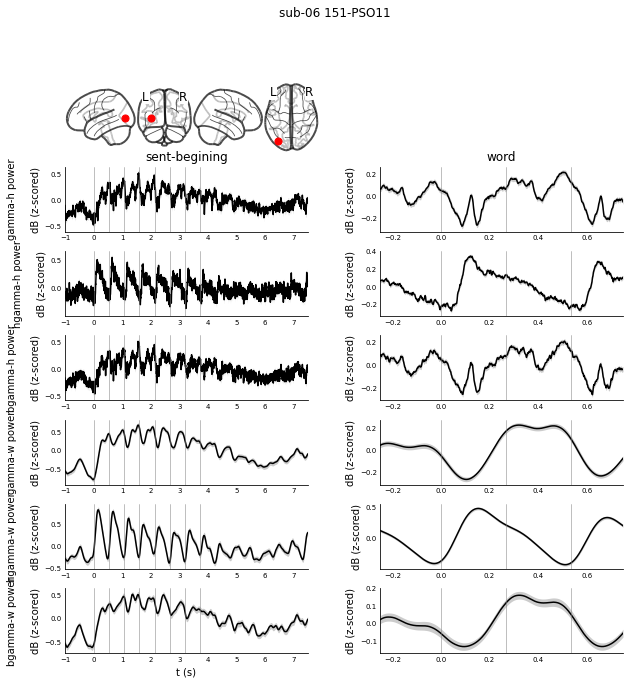

In [11]:
bands = [     
  {"name": "gamma-h", "fmin" : 30, "fmax" : 70, "method": "hilbert" },   
  {"name": "hgamma-h", "fmin" : 70, "fmax" : 140, "method": "hilbert" },
  {"name": "bgamma-h", "fmin" : 30, "fmax" : 140, "method": "hilbert" },
  {"name": "gamma-w", "fmin" : 30, "fmax" : 70, "method": "wavelet",'nf':10,'norm':'f'},
  {"name": "hgamma-w", "fmin" : 70, "fmax" : 140, "method": "wavelet",'nf':10,'norm':'f'},
  {"name": "bgamma-w", "fmin" : 30, "fmax" : 140, "method": "wavelet",'nf':10,'norm':'f'},
]

#pr.raw2TFR_wrap(subs=['sub-06'],bands=bands)

ov.channel_overview('trace','sub-06','151-PSO11',bands=bands,ep_setups =ep_setups)

### Navigate
1. [Litterature review of methods](#litrev)
1. [Setup](#setup)
1. [Rejection](#rejection)
1. [Referencing](#ref)
1. [TFAnalysis](#TF)
1. [Baseline](#baseline)
1. [ROIs](#ROIs)
1. [Pipeline description](#top)

<a id='baseline'></a>
# Baseline

Two Baseline options:
- **None** (`baseline = None`)
- **Trialwise** (`baseline = epochs_setup`) baseline with respect to a small time window preceding the first event in the trial

### 2 Examples from sub-06

1. **151-PSO11**: in the beta band the trialwise baseline seems to be doing more harm than good (there are many examples like this, if the baseline period is noisy the trialwise baseline introduces noise)
1. **186-PBT5**: what's happening in hgamma? epileptic spikes?

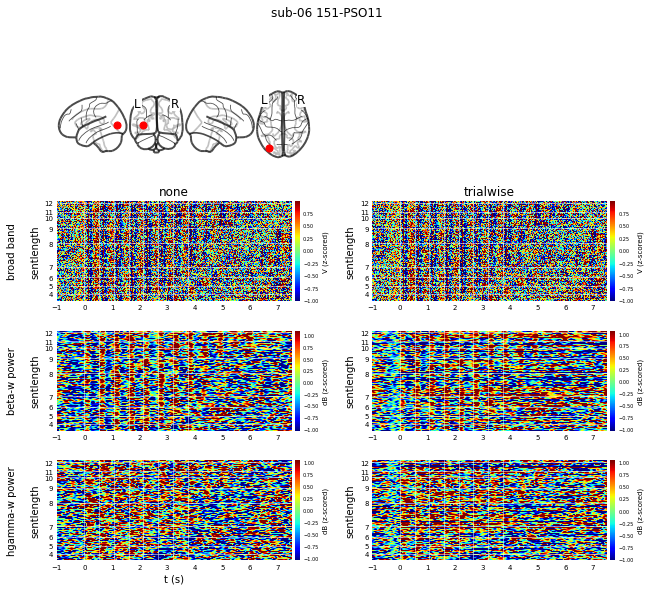

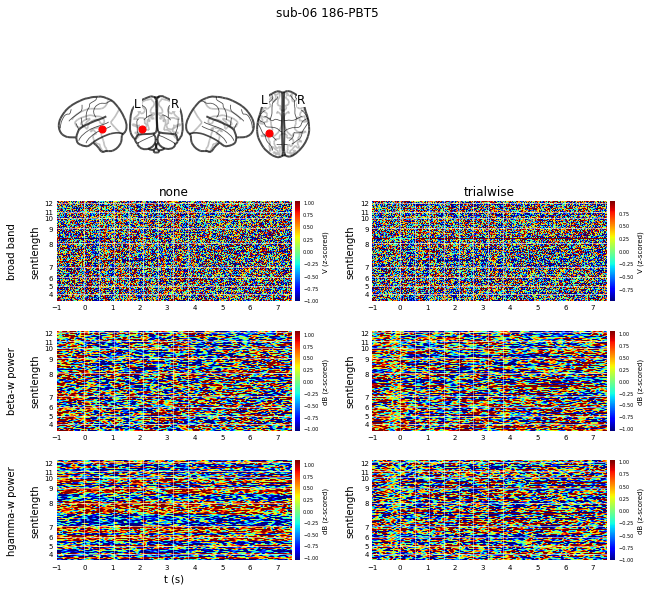

In [4]:
bands = [     
  {"name": "broad", "fmin" : 0.1,  "fmax" : None, "method": 'filter'},   
  {"name": "beta-w", "fmin" : 30, "fmax" : 70, "method": "wavelet",'nf':10,'norm':'f'},
  {"name": "hgamma-w", "fmin" : 70, "fmax" : 140, "method": "wavelet",'nf':10,'norm':'f'},
] 

baseline = {'key' : 'position', "values" : [ 1 ], "tmin" : -.4, "tmax" : 0,"smooth":0.,"clip":3}

ep_setups =  [  
    {"name" : "none",'key' : 'position', "values" : [ 1 ], "tmin" : -1., "tmax" : 7.5, 'baseline' : None, "xticks": [n for n in range(8)],"smooth":0.,"clip":3,"split":"sentlength"  },         
    {"name" : "trialwise",'key' : 'position', "values" : [ 1 ], "tmin" : -1., "tmax" : 7.5, 'baseline' : baseline, "xticks": [n for n in range(8)],"smooth":0.,"clip":3,"split":"sentlength"  }, 
                ]

ov.channel_overview('ERP','sub-06','151-PSO11',bands=bands,ep_setups=ep_setups,key='sentlength')
ov.channel_overview('ERP','sub-06','186-PBT5',bands=bands,ep_setups=ep_setups,key='sentlength')

# ROIs

The pipeline allows to add virtual channels to the `mne.raw` objects with the average of a list of channels. To distinguish virtual channels from real ones the former are given names with the format `ROI-XXX`.

For the pipeline, the only two differences between ROI and real channels are that
1. ROI channels are ignored when computing new ROIs
1. When the function that retrieves channel coords (`get_coords(raw,picks=['ROI-XXX'])`) is passed a one element list of picks with a single ROI channel it returns an array of coordinates of all channels in the ROI. (Otherwise the virtual ROI channel has coordinates as the average of its components)

`pr.add_ROI_from_atlas(subs=subs, bands=bands)` groups all channels into ROIs from the HarvardOxford atlas.

In [ ]:
bands = [     
  {"name": "broad", "fmin" : 0.1,  "fmax" : None, "method": 'filter'},
  {"name": "theta-ph", "fmin" : 4, "fmax" : 8, "method": "complex" },
  {"name": "theta-h", "fmin" : 4, "fmax" : 8, "method": "hilbert" },  
  {"name": "alpha-ph", "fmin" : 8, "fmax" : 13, "method": "complex" },
  {"name": "alpha-h", "fmin" : 8, "fmax" : 13, "method": "hilbert" },  
  {"name": "beta-w", "fmin" : 13, "fmax" : 30, "method": "wavelet",'nf':10,'norm':'f' },
  {"name": "gamma-w", "fmin" : 30, "fmax" : 70, "method": "wavelet",'nf':10,'norm':'f'},
  {"name": "hgamma-w", "fmin" : 70, "fmax" : 140, "method": "wavelet",'nf':10,'norm':'f'},
] 

subs = ['sub-06']

pr.raw2TFR_wrap(subs=subs,bands=bands)

pr.add_ROI_from_atlas(subs=subs, bands=bands)

We can now use `channel_overview` to make ROI figures.  
We will show all the bands with three epochs setups: sentence begining, sentence ending and word and we will only show trials in the Main block.

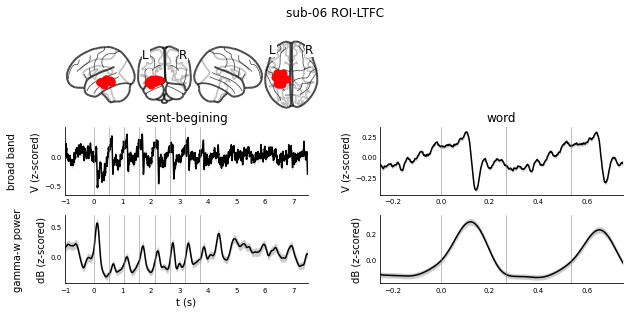

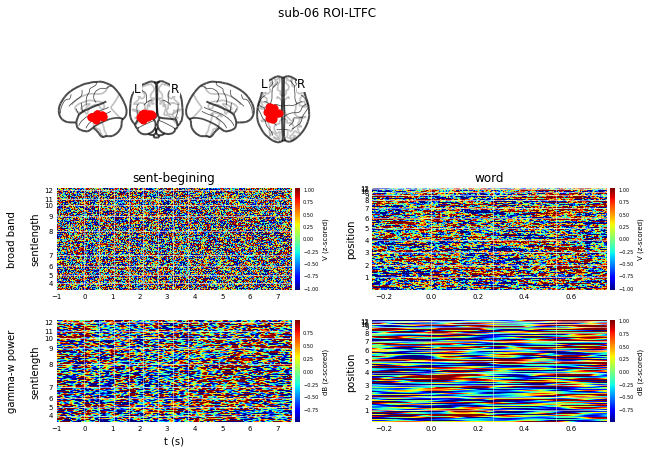

In [2]:
# define bands
bands = [     
  {"name": "broad", "fmin" : 0.1,  "fmax" : None, "method": 'filter'},
  {"name": "gamma-w", "fmin" : 30, "fmax" : 70, "method": "wavelet",'nf':10,'norm':'f'},
] 

# define epochs
ep_setups = [  
    {"name" : "sent-begining",'key' : 'position', "values" : [ 1 ], "tmin" : -1., "tmax" : 7.5, 'baseline' : None, "xticks": [n for n in range(8)],"smooth":0.,"clip":3,"split":"sentlength" ,"query":"blocktype=='Main'"}, 
    {"name" : "sent-begining",'key' : 'position_end', "values" : [ -1 ], "tmin" : -7, "tmax" : 1.5, 'baseline' : None, "xticks": [-n for n in range(8)],"smooth":0.,"clip":3,"split":"sentlength","query":"blocktype=='Main'" }, 
    {"name" : "word" ,'key' : "eventtype" ,"values" :  ["wordonset"], "tmin" : -0.25,"tmax" : .75, 'baseline' : None, "xticks": [0.5*n for n in range(3)],"smooth":0.,"clip":3,"split":"position","query":"blocktype=='Main'" }
]

ov.channel_overview('trace','sub-06','ROI-LTFC',bands=bands,plot=True,save=False)
ov.channel_overview('ERP','sub-06','ROI-LTFC',bands=bands,plot=True,save=False)

<a id='top'></a>
# IntraCranial pipeline description

1. Modules
1. Folder structure
1. IO

## Modules

1. **Preprocessing**: Make mne raw files, basic cleaning (notch filter, resaple, low/high pass filter), rejection, referencing
1. **Inference**:
1. **Regressions**:

Other
1. **Figures**:
1. **Overview**: make figures with evoked responses for all channels / subjects / bands.
1. **Common functions**:


#### Tip to navigate the code:
Most functions come in pairs of low level and high level functions (names follow the pattern `func()`,`func_wrap()`)

**Low level functions** take genereal mne objects as arguments (raw, epochs). They are meant to be easily implemented in any MNE based code.  
**High level functions** are basically wraps for low level functions, they perform four main operations: (i) Loop over subjects/bands/conditions... (ii) load data, (iii) call low level functions, (iv) save results and or modified data. Wraps need to "know" the folder structure (among other things) and therefore are functional as long as the basic structure of the pipeline is respected.


## Folder structure

BIDS naming and folder structure

- **Code**
    - `ICPipeline.ipynb`
    - `static_parameters.py`
    - `run.py`
    - utils
        - modules
- **Data** 
    - raw
        - sub-XX 
            - `sub-XX_metadata.csv`
            - `sub-XX_raw.fif`
    - derivatives
        - sub-XX
            - `sub-XX_raw.fif`
            - `sub-XX_band-XXXX_raw.fif`
- **Figures**
    - overview
        - `sub-XX_overview.pdf`
    
## IO

### In

Raw data (from `Data/raw/sub-XX`)

1. ieeg data in one single `raw.fif` file with mne raw objects with **montage included**, **line-noise removed** and **resampled** to desired sampling rate.
1. metadata in a `csv` file

If montage is not included coords are read as `nan` for compatibility with the rest of the pipeline.


### Out

Preprocessed data (at `Data/derivatives/sub-XX`)

1. `mne.raw` stored as `sub-XX_band-XXX_raw.fif`